In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
__imp

Libraries have been loaded


In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

import xgboost as xgb
import lightgbm as lgb

basepath = os.path.expanduser('~/Desktop/src/ml/lordofmachines/')

/home/abhishek/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
CAMPAIGNS_PATH = os.path.join(basepath, 'data/raw/campaign_data.csv')

# TRAIN_PATH     = os.path.join(basepath, 'data/processed/train.feather')
# TEST_PATH      = os.path.join(basepath, 'data/processed/test.feather')

TRAIN_PATH     = os.path.join(basepath, 'data/processed/val/ctypev5/tr.feather')
TEST_PATH      = os.path.join(basepath, 'data/processed/val/ctypev5/val.feather')

In [5]:
%%time

campaigns = pd.read_csv(f'{CAMPAIGNS_PATH}')
train     = pd.read_feather(f'{TRAIN_PATH}')
test      = pd.read_feather(f'{TEST_PATH}')

CPU times: user 195 ms, sys: 70.8 ms, total: 266 ms
Wall time: 269 ms


In [6]:
traintest = pd.concat((train, test))
ntrain    = len(train)

del train, test
gc.collect();

## Feature Engineering

In [7]:
%%time

traintest.loc[:, 'send_day']     = traintest.send_date.dt.day
traintest.loc[:, 'send_hour']    = traintest.send_date.dt.hour
traintest.loc[:, 'send_weekday'] = traintest.send_date.dt.weekday

traintest.loc[:, 'communication_type'] = pd.factorize(traintest.loc[:, 'communication_type'])[0]

num_emails_sent = traintest.groupby('user_id').size()
traintest.loc[:, 'num_emails_sent'] = traintest.user_id.map(num_emails_sent)

num_diff_email_types                     = traintest.groupby('user_id')['communication_type'].nunique()
traintest.loc[:, 'num_diff_email_types'] = traintest.user_id.map(num_diff_email_types)

FEATURES = ['communication_type', 'send_day', 'send_hour', 'send_weekday',
            'total_links', 'no_of_internal_links', 'no_of_images', 'no_of_sections',
            'num_emails_sent', 'num_diff_email_types'
           ]

X_trn = traintest.iloc[:ntrain][FEATURES]
y_trn = traintest.iloc[:ntrain]['is_click']

X_val = traintest.iloc[ntrain:][FEATURES]
y_val = traintest.iloc[ntrain:]['is_click']

print('Train nulls:\n{}'.format(X_trn.isnull().sum()))
print('\nTest nulls:\n{}'.format(X_val.isnull().sum()))

Train nulls:
communication_type      0
send_day                0
send_hour               0
send_weekday            0
total_links             0
no_of_internal_links    0
no_of_images            0
no_of_sections          0
num_emails_sent         0
num_diff_email_types    0
dtype: int64

Test nulls:
communication_type      0
send_day                0
send_hour               0
send_weekday            0
total_links             0
no_of_internal_links    0
no_of_images            0
no_of_sections          0
num_emails_sent         0
num_diff_email_types    0
dtype: int64
CPU times: user 1.53 s, sys: 414 ms, total: 1.95 s
Wall time: 1.97 s


## Train and Validate

In [21]:
m = RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_leaf=5, random_state=SEED, n_jobs=4)
m.fit(X_trn, y_trn)
val_preds = m.predict_proba(X_val)[:, 1]
print('AUC score: {}'.format(roc_auc_score(y_val, val_preds)))

AUC score: 0.575760482268129


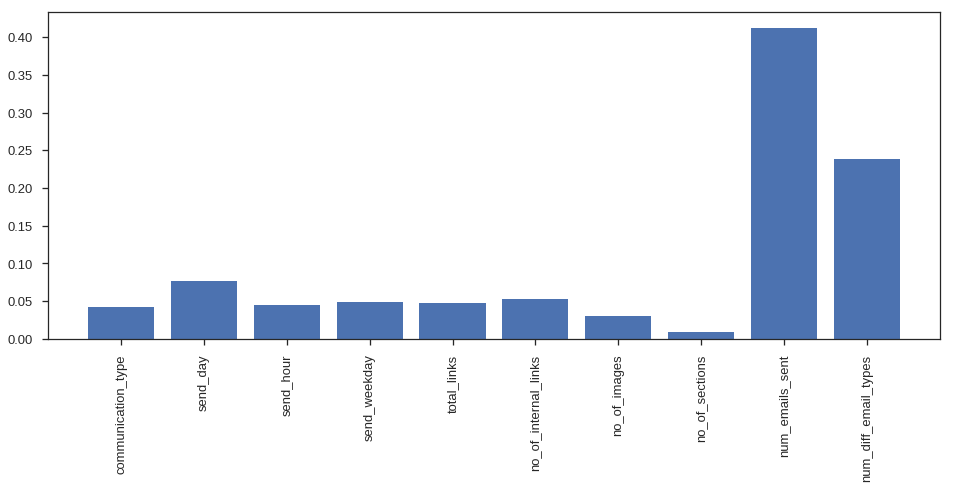

In [16]:
plt.figure(figsize=(16, 6))
plt.bar(np.arange(len(FEATURES)), m.feature_importances_)
plt.xticks(np.arange(len(FEATURES)), FEATURES, rotation=90);

In [12]:
X_trn

communication_type  send_day  send_hour  send_weekday  total_links  \
0                        0         6         22             0          104   
1                        1         1         22             1           75   
2                        0         2         16             2           15   
3                        0        18         15             4           10   
4                        0        28         15             3          119   
5                        1         1         18             5           67   
6                        2         5         14             2           18   
7                        2         5         14             2           18   
8                        1         1         22             1           75   
9                        1         1         22             1           75   
10                       0        19         12             2           24   
11                       0         3         17             3           13   
12                       0         6         22             0          104   
13                       0        28         15             3          119   
14                       1         1         20             4           88   
15                       1         1         22             1           75   
16                       0         3         17             3           13   
17                       1         2         12             3           67   
18                       0        28         15             3          119   
19                       0        28         15             3          119   
20                       0         6         23             0          104   
21                       2         5         14             2           18   
22                       0        28         15             3          119   
23                       0        28         15             3          119   
24                       0        28         15             3          119   
25                       1         1         22             1           75   
26                       3        14         13             3            7   
27                       1         1         19             4           88   
28                       0         3         17             3           13   
29                       1         2         12             3           67   
...                    ...       ...        ...           ...          ...   
845414                   2         5         14             2           18   
845415                   3        21         23             3            8   
845416                   0         6         23             0          104   
845417                   2         5         14             2           18   
845418                   0         3         17             3           13   
845419                   3        11         18             0            7   
845420                   1         1         22             1           75   
845421                   0         3         17             3           13   
845422                   0        19         12             2           24   
845423                   0        28         15             3          119   
845424                   1         2         10             0          203   
845425                   0        19         12             2           24   
845426                   0        19         12             2           24   
845427                   1         1         20             4           88   
845428                   2         5         14             2           18   
845429                   2         5         14             2           18   
845430                   1         1         22             1           75   
845431                   1         1         18             5           67   
845432                   0        19         12             2           24   
845433                   0    

In [13]:
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'eta': .1,
    'max_depth': 4,
    'gamma': 1,
    'seed': SEED,
    'nthread': 4
}

dtrain = xgb.DMatrix(X_trn, y_trn, feature_names=FEATURES)
deval  = xgb.DMatrix(X_val, y_val, feature_names=FEATURES)

watchlist = [(dtrain, 'train'), (deval, 'eval')]

num_boost_round = 1000
early_stopping_rounds = 100

m = xgb.train(params, 
              dtrain, 
              num_boost_round, 
              early_stopping_rounds=early_stopping_rounds, 
              evals=watchlist, 
              verbose_eval=20)

[0]	train-auc:0.593956	eval-auc:0.542436
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 100 rounds.
[20]	train-auc:0.62166	eval-auc:0.54299
[40]	train-auc:0.636713	eval-auc:0.555405
[60]	train-auc:0.644433	eval-auc:0.571158
[80]	train-auc:0.648669	eval-auc:0.573433
[100]	train-auc:0.650182	eval-auc:0.573739
[120]	train-auc:0.651379	eval-auc:0.57303
[140]	train-auc:0.651968	eval-auc:0.572839
[160]	train-auc:0.65274	eval-auc:0.573706
[180]	train-auc:0.653328	eval-auc:0.572818
Stopping. Best iteration:
[94]	train-auc:0.649764	eval-auc:0.574471



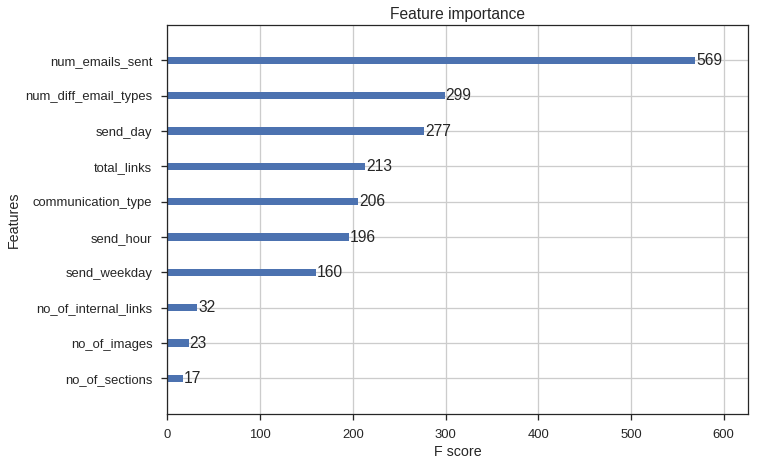

In [14]:
xgb.plot_importance(m);

In [15]:
params = {
    'application': 'binary',
    'metric': 'auc',
    'learning_rate': .1,
    'min_data_in_leaf': 20,
    'num_leaves': 31,
    'nthread': 4
}

ltrain = lgb.Dataset(X_trn, y_trn, feature_name=FEATURES)
leval  = lgb.Dataset(X_val, y_val, feature_name=FEATURES)

valid_sets  = [ltrain, leval]
valid_names = ['train', 'eval']

num_boost_round = 1000
early_stopping_rounds = 100

m = lgb.train(params, 
              ltrain, 
              num_boost_round, 
              early_stopping_rounds=early_stopping_rounds, 
              valid_names=valid_names,
              valid_sets=valid_sets,
              verbose_eval=20)

Training until validation scores don't improve for 100 rounds.
[20]	train's auc: 0.63707	eval's auc: 0.563943
[40]	train's auc: 0.64605	eval's auc: 0.563262
[60]	train's auc: 0.65229	eval's auc: 0.573238
[80]	train's auc: 0.655328	eval's auc: 0.57426
[100]	train's auc: 0.657578	eval's auc: 0.577703
[120]	train's auc: 0.659235	eval's auc: 0.58314
[140]	train's auc: 0.660753	eval's auc: 0.589145
[160]	train's auc: 0.662205	eval's auc: 0.587208
[180]	train's auc: 0.663328	eval's auc: 0.587373
[200]	train's auc: 0.66416	eval's auc: 0.586448
[220]	train's auc: 0.665258	eval's auc: 0.585584
Early stopping, best iteration is:
[138]	train's auc: 0.660582	eval's auc: 0.590314


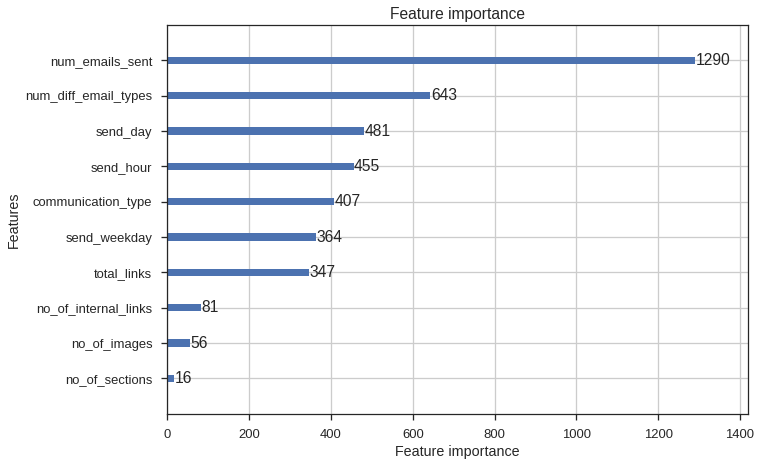

In [16]:
lgb.plot_importance(m);

## Full Training

In [10]:
%%time

m = RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_leaf=5, random_state=SEED, n_jobs=4)
m.fit(X_trn, y_trn)
preds = m.predict_proba(X_val)[:, 1]

CPU times: user 3min 16s, sys: 1.16 s, total: 3min 17s
Wall time: 1min 1s


## Submission PB Leaderboard Score: 0.535707423922237

In [11]:
sub = pd.read_csv('../data/raw/sample_submission_4fcZwvQ.csv')
sub.loc[:, 'is_click'] = preds
sub.to_csv('../submissions/submission9.csv', index=False)